Установка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify # pip install squarify (algorithm for treemap)
import scipy.stats as stats #pip install scipy
from scipy.stats import norm

Чтение файла базы данных:

In [2]:
df = pd.read_csv("AdSmartABdata - AdSmartABdata.csv")

In [3]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


## Анализ и визуализация данных 

### Первичный анализ данных

DataFrame содержит столбцы auction_id, experiment, date, hour, device_make, platform_os, browser, yes, no.

In [4]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


Рассмотрим, какие типы данных содержат столбцы

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


Датафрейм не имеет пустых значений. Столбцы auction_id, experiment, date, device_make, browser хранят типы данных object, столбцы hour, platform_os, yes, no - int64.

Проверка на дубликаты записей

In [6]:
num_duplicates = sum(df.duplicated(subset=['auction_id']))

print(f'Количество дубликатов: {num_duplicates}')

Количество дубликатов: 0


Файл не имеет дупликатов

Посмотрим, сколько уникальных значений в каждом столбце

In [7]:
df.nunique()

auction_id     8077
experiment        2
date              8
hour             24
device_make     269
platform_os       3
browser          15
yes               2
no                2
dtype: int64

Рассчитаем количество пользователей в каждой группе.

In [8]:
groups = df['experiment'].value_counts()
groups

experiment
control    4071
exposed    4006
Name: count, dtype: int64

Построим круговую диаграмму.

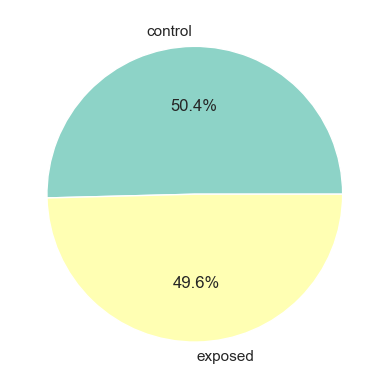

In [9]:
sns.set_theme(style="whitegrid", palette='Set3')
plt.pie(groups.values, autopct='%.1f%%', labels=groups.index);

### Ответы на анкету

В базе нет столбца, показывающего отсутствие ответа на анкету, если оба столбца yes и no имеют значение 0. Добавим столбец response для явной пометки. Столбец response будет иметь значение "yes", если yes=1 и "no", если no=1. Если столбцы yes и no равны нулю, столбец response имеет значение 'no response'.

In [10]:
def get_response(row):
    if row[0] == 1:
        res = 'yes'
    elif row[1] == 1:
        res = 'no'
    else:
        res = 'no response'
        
    return res
df['response'] = df[['yes', 'no']].apply(get_response, axis=1)

Рассмотрим соотношение отвеченных и неотвеченных анкет. 
Для этого посчитаем количество по каждому значению с помощью value_counts. Эта функция возвращает объект, содержащий количество уникальных значений.

In [11]:
no_res = df['response'].value_counts()
no_res

response
no response    6834
no              671
yes             572
Name: count, dtype: int64

Визуализируем полученные данные с помощью круговой диаграммы. Используем функцию pie библиотеки matplotlib.

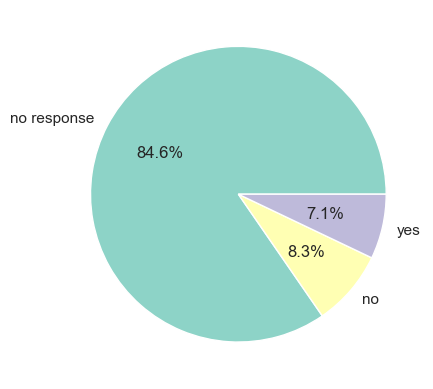

In [12]:
sns.set_theme(style="whitegrid", palette='Set3')
plt.pie(no_res.values, autopct='%.1f%%', labels=no_res.index);

Как видно, преобладают неотвеченные анкеты - 84.6%.

Рассмотрим количество каждого ответа и неотвеченных анкет в каждой группе. Необходимо создать таблицу с кросс-табуляцией, отображающую частоту, с которой появляются определенные группы данных. Применим функцию crosstab(). В качестве данных используем колонки response и experiment.

In [13]:
data = pd.crosstab(df['response'], df['experiment']).reset_index()
data.head()

experiment,response,control,exposed
0,no,322,349
1,no response,3485,3349
2,yes,264,308


Построим на основе полученных данных столбчатые гистограммы.

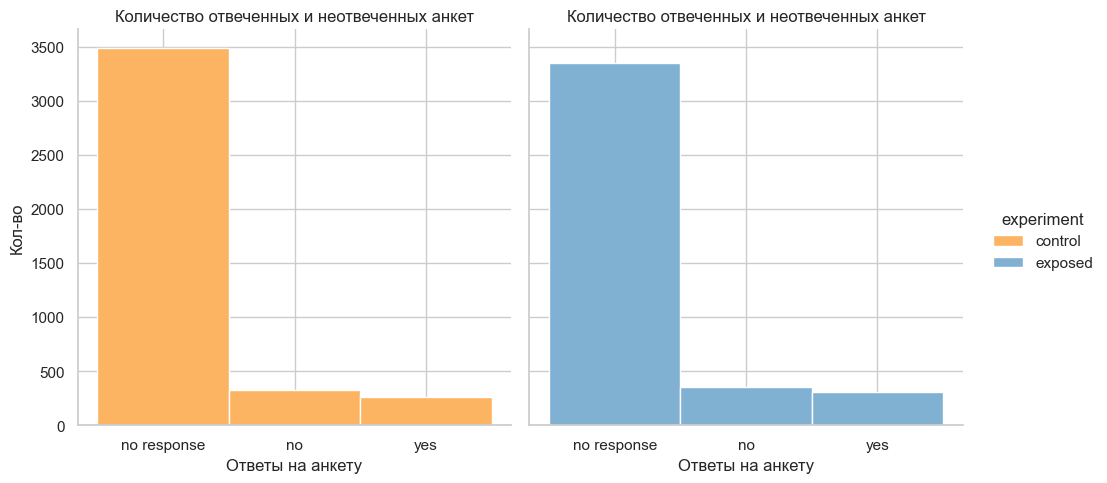

In [14]:
sns.set_theme(style="whitegrid", palette=['#fdb462','#80b1d3'])
ax = sns.displot(df.sort_values(by='experiment'), x='response', col='experiment', hue='experiment', alpha=1)
ax.set_ylabels('Кол-во')
ax.set_xlabels('Ответы на анкету')
ax.set_titles('Количество отвеченных и неотвеченных анкет')

Посчитаем процентное соотношение каждого ответа на анкету и неотвеченных анкет в зависимости от группы. Для этого построим сводную таблицу с помощью pivot_table. Создадим также функцию get_category_percent, которая будет рассчитывать проценты в каждой строке.

In [15]:
def get_category_percent(row, decimal=1):
    return round(row/max(row)*100, decimal)

df_response = df.pivot_table(index='experiment',
                  columns='response', 
                  values='auction_id',
                  aggfunc='count',
                  fill_value=0,
                  margins=True,
                  margins_name='Total')

df_response = df_response.apply(get_category_percent, axis=1)
df_response.columns.name = 'response %'
df_response = df_response[['yes', 'no', 'no response']]
df_response

response %,yes,no,no response
experiment,,,
control,6.5,7.9,85.6
exposed,7.7,8.7,83.6
Total,7.1,8.3,84.6


Из полученной таблицы видно, что в обоих группах количество неотвеченных анкет значительно выше, чем на которые ответили.
Как мы видим, обычно (~83-85%) пользователи не отвечают на вопросы анкеты.
Сходное количество пользователей (6,5–8,7 %) ответили «да» или «нет».

Рассмотрим соотношение положительных и отрицательных ответов в анкете в каждой группе. Для этого посчитаем соотношение ответов yes и no. Сначала очистим данные от 'no response', так как они не будут полезны в дальнейшем анализе A/B-теста.

In [16]:
data_response = df[(df['yes'] == 1) | (df['no'] == 1)]

In [17]:
exp_response = data_response[(data_response['experiment'] == 'exposed')]['response'].value_counts()
exp_response

response
no     349
yes    308
Name: count, dtype: int64

Text(0.5, 1.0, 'Распределение ответов на анкету в группе exposed')

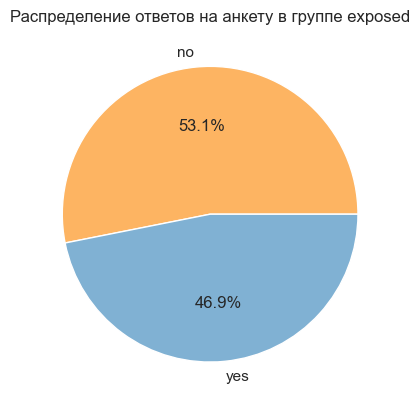

In [18]:
sns.set_theme(style="whitegrid", palette=['#fdb462','#80b1d3'])
plt.pie(exp_response.values, autopct='%.1f%%', labels=exp_response.index);
plt.title('Распределение ответов на анкету в группе exposed')

In [19]:
ctr_response = data_response[(data_response['experiment'] == 'control')]['response'].value_counts()
ctr_response

response
no     322
yes    264
Name: count, dtype: int64

Text(0.5, 1.0, 'Распределение ответов на анкету в группе control')

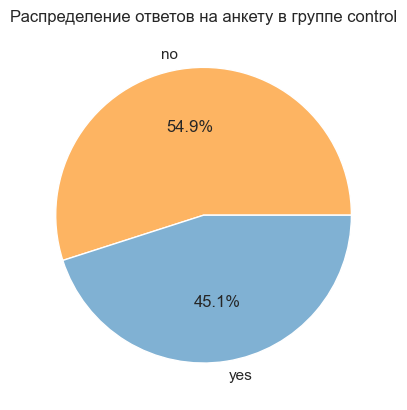

In [20]:
sns.set_theme(style="whitegrid", palette=['#fdb462','#80b1d3'])
plt.pie(ctr_response.values, autopct='%.1f%%', labels=exp_response.index);
plt.title('Распределение ответов на анкету в группе control')

Распределение ответов в каждой группе одинаковое. 

### Анализ по дням

Определим длительность эксперимента.

In [21]:
df['date'].min()

'2020-07-03'

In [22]:
df['date'].max()

'2020-07-10'

Эксперимент длился 7 дней - с 03.07.2020 по 10.07.2020

Построим график, отображающий показы рекламы по дням.

Text(0.5, 1.0, 'Количество пользователей в зависимости от даты')

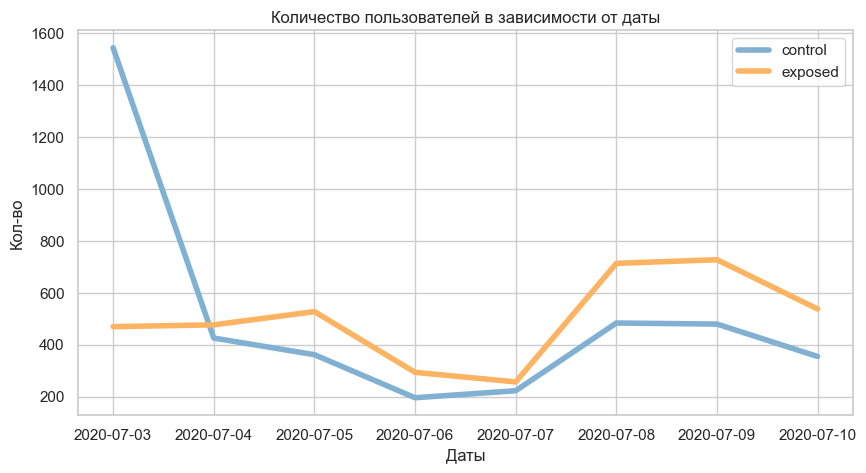

In [23]:
sns.set_theme(style="whitegrid", palette="Set3")

fig, ax = plt.subplots(figsize=(10,5))

g = sns.lineplot(data=df.groupby(['experiment', 'date'])['date'].count()['control'], 
                ax=ax, label='control', color='#80b1d3', linewidth = 4)
g = sns.lineplot(data=df.groupby(['experiment', 'date'])['date'].count()['exposed'], 
                ax=ax, label='exposed', color='#fdb462', linewidth = 4)
ax.set_ylabel('Кол-во')
ax.set_xlabel('Даты')
ax.set_title('Количество пользователей в зависимости от даты')

В первый день эксперимента количество пользователей в контрольной группе было намного больше, чем в экспонированной группе. В другие дни количество пользователей было немного выше в экспериментальной группе.

Рассмотрим соотношение положительных и отрицательных ответов в зависимости от дня.

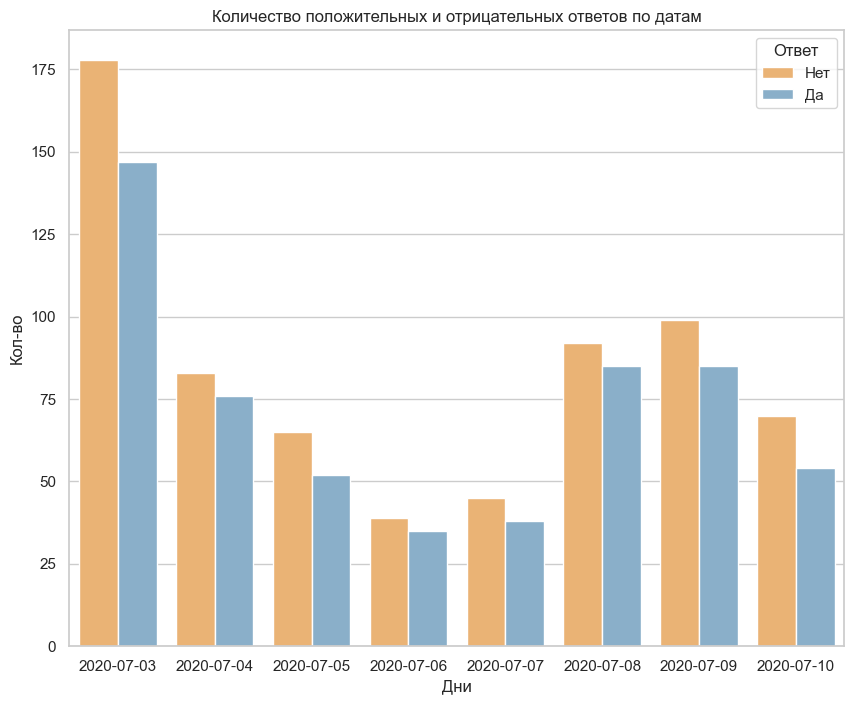

In [24]:
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid", palette=['#fdb462','#80b1d3'])

ax = sns.countplot(x="date", data=data_response, hue='yes', order=['2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10'] )
ax.set_title('Количество положительных и отрицательных ответов по датам')
ax.set_xlabel('Дни')
ax.set_ylabel('Кол-во')
plt.legend(['Нет', 'Да'], title='Ответ')
plt.show()

Построим гистограммму, отображающую распределение отвеченных и неотвеченных анкет в зависимости от дня.

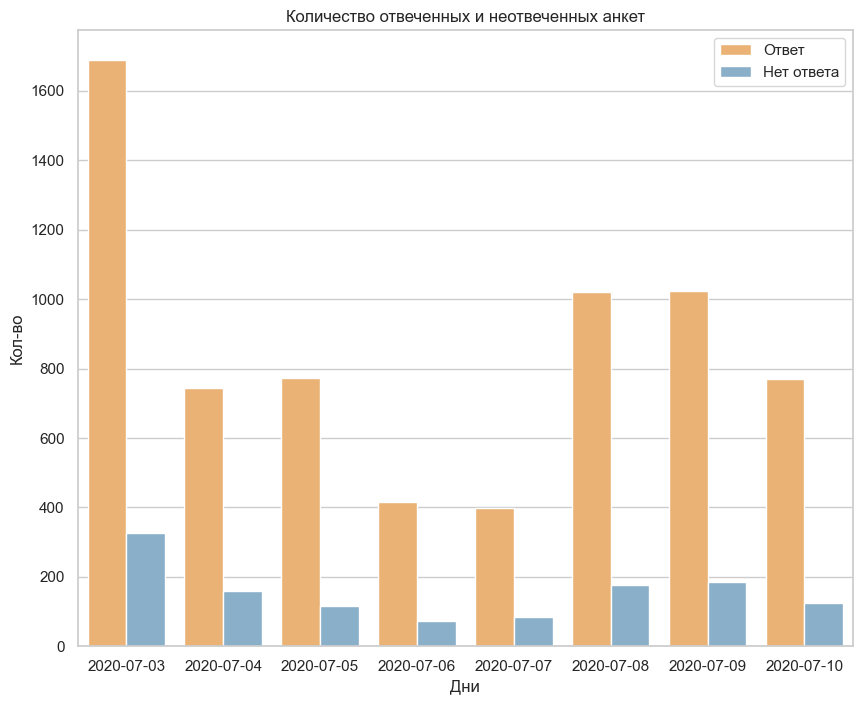

In [25]:
df.loc[df["response"] != "no response", "response"] = 'response'

plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid", palette=['#fdb462','#80b1d3'])

ax = sns.countplot(x="date", data=df, hue='response', order=['2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10'] )
ax.set_title('Количество отвеченных и неотвеченных анкет')
ax.set_xlabel('Дни')
ax.set_ylabel('Кол-во')
plt.legend(['Ответ', 'Нет ответа'])

Как видно из гистограмм, во все дни преобладали отрицательные ответы на анкету, а также неотвеченные анкеты над отвеченными.

### Исследование часов

Проведем исследование эксперимента по часам.

Рассмотрим количество показов анкеты в каждой группе по часам.

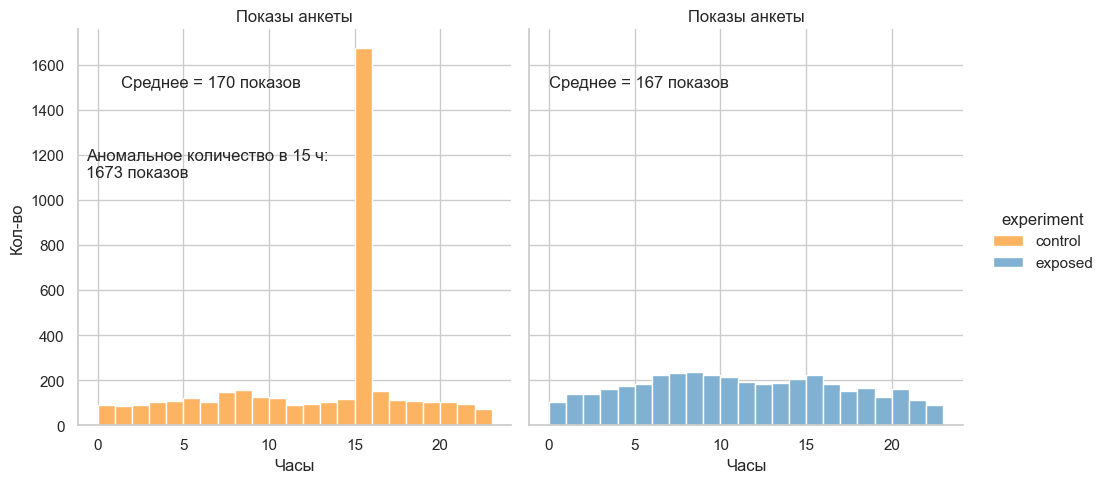

In [26]:
ax = sns.displot(df.sort_values(by='experiment'), x='hour', col='experiment', 
            bins=range(24), hue='experiment', 
            palette=['#fdb462','#80b1d3'], alpha=1)

plt.text(-25, 1500, "Среднее = {:.0f} показов"\
         .format(df[df['experiment']=='control']\
                 .groupby('hour')['experiment'].count().mean()))

plt.text(-27, 1100, "Аномальное количество в 15 ч:\n{:.0f} показов"\
         .format(df[df['experiment']=='control']\
                 .groupby('hour')['experiment'].count().max()))

plt.text(0, 1500, "Среднее = {:.0f} показов"\
         .format(df[df['experiment']=='exposed']\
                 .groupby('hour')['experiment'].count().mean()))
ax.set_ylabels('Кол-во')
ax.set_xlabels('Часы')
ax.set_titles('Показы анкеты')

plt.show()

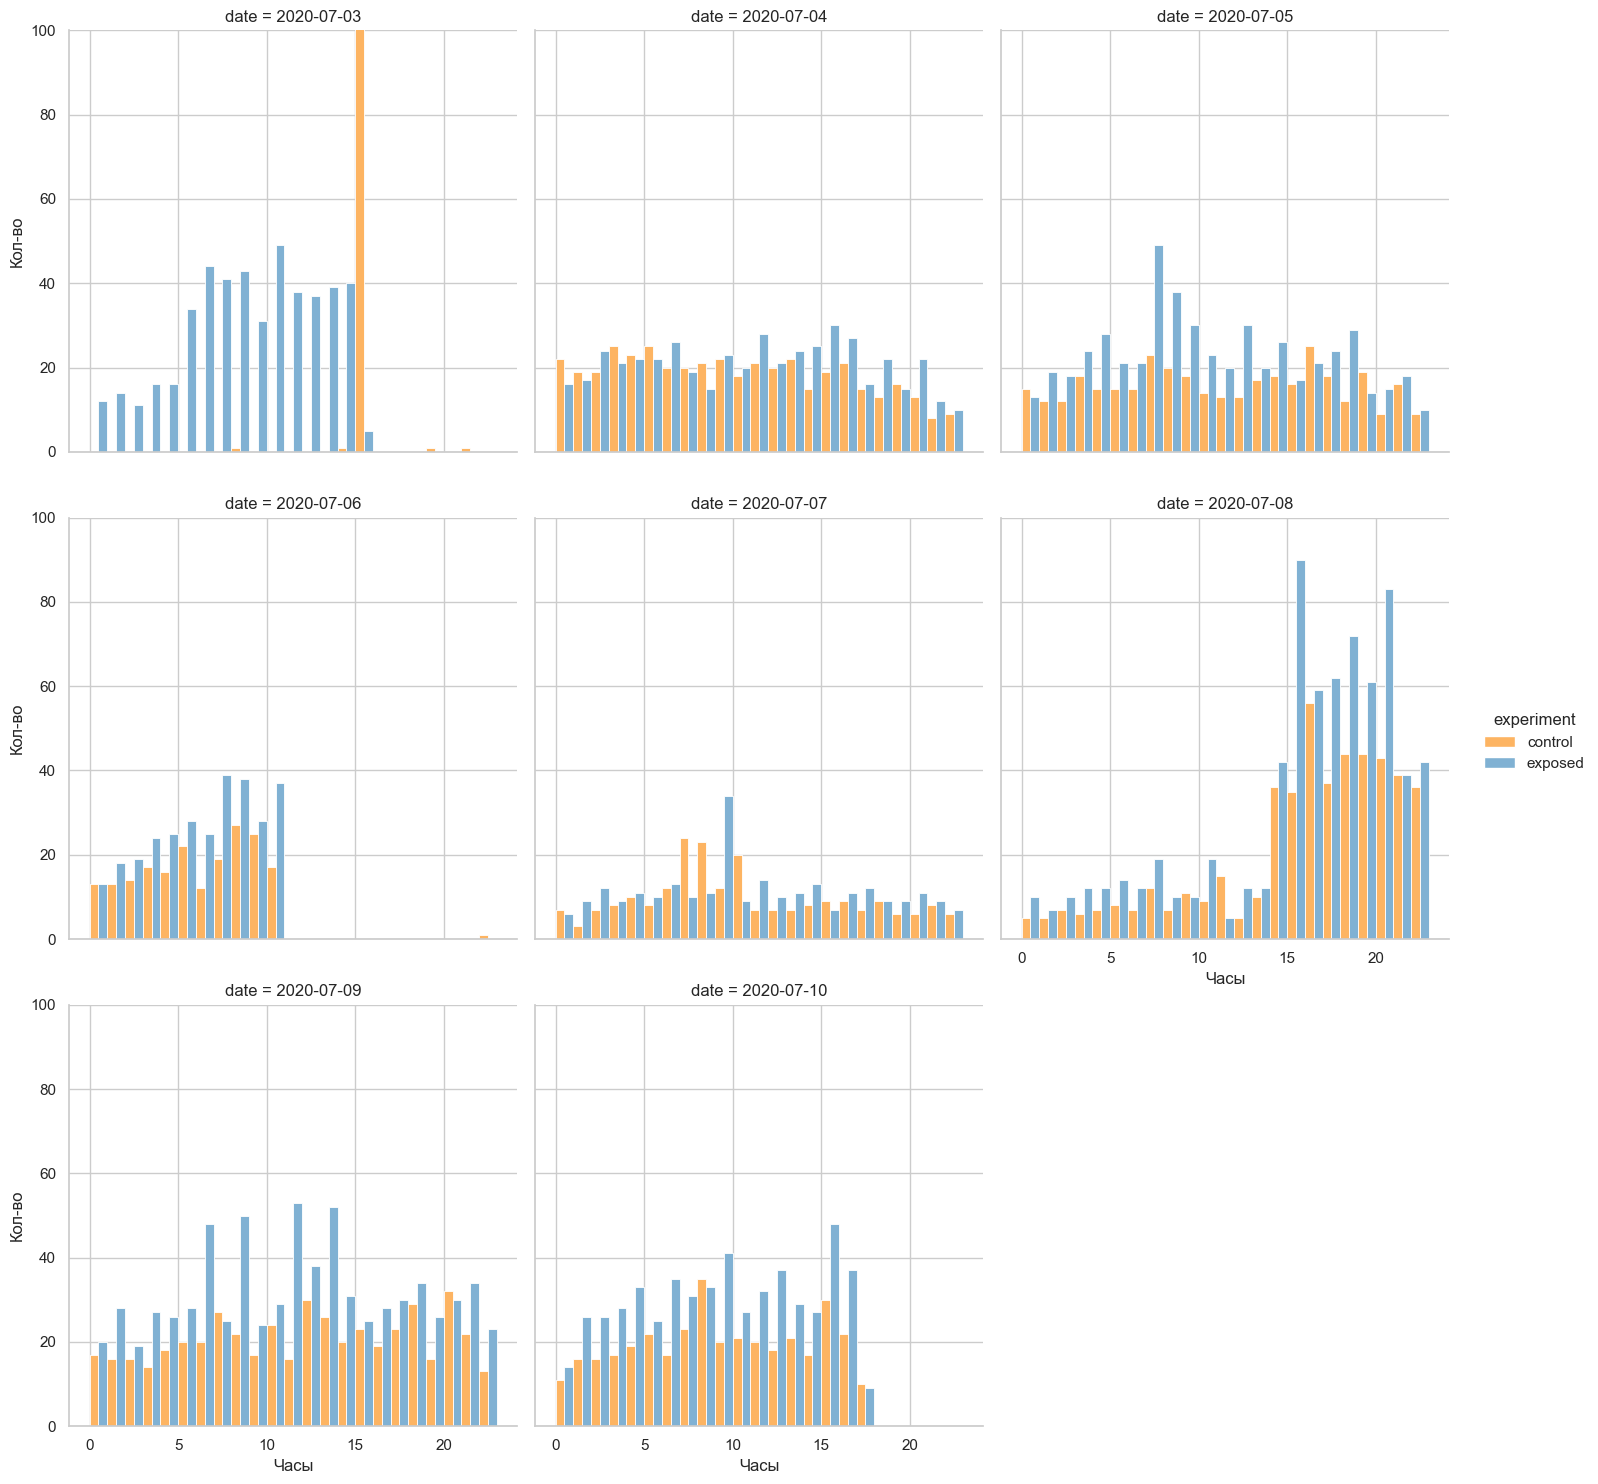

In [27]:
ax = sns.displot(df.sort_values(by=['date','experiment']), x='hour', col='date', bins=range(24), 
            hue='experiment', palette=['#fdb462','#80b1d3'], alpha=1,
            multiple="dodge", col_wrap=3, facet_kws=dict(sharey=True))
plt.ylim([0, 100])

ax.set_ylabels('Кол-во')
ax.set_xlabels('Часы')

plt.show()

У нас есть некоторые различия в часах между двумя группами в разные дни, но в первый день эксперимента мы получили экстремальные значения пользователей в контрольной группе в течение 15 часов.

### Девайсы

Рассмотрим, какими девайсами использовались пользователями для просмотра анкеты. При первоначальном анализе данных выявлено, что всего 269 уникальных значений в столбце "device_make". Выясним, сколько уникальных девайсов в выборке отвеченных анкет.

In [28]:
data_response.device_make.nunique()

115

Как видно, не все девайсы попали в эту выборку. Выявим уникальные значения device_make.

In [29]:
data_response.device_make.unique()

array(['E5823', 'Generic Smartphone', 'Samsung SM-A202F', 'I3312',
       'MRD-LX1', 'Samsung SM-G935F', 'Moto $2', 'Samsung SM-J600FN',
       'Samsung SM-A105FN', 'Samsung SM-G930F', 'Samsung SM-G981B',
       'Samsung SM-G973F', 'ELE-L09', 'Samsung SM-G950F',
       'Samsung SM-G960F', 'Samsung SM-N960F', 'VOG-L09',
       'Samsung SM-A705FN', 'Samsung SM-A405FN', 'LG-$2',
       'Samsung SM-A320FL', 'ANE-LX1', 'POT-LX1', 'Samsung SM-A505FN',
       'Samsung SM-A300FU', 'Samsung SM-A520F', 'Samsung SM-A750FN',
       'Samsung SM-J330FN', 'OnePlus ONEPLUS A5000', 'STF-L09', 'HTC 10',
       'Samsung SM-J610FN', 'iPhone', 'Samsung SM-G900F', 'VOG-L29',
       'XiaoMi Redmi Note 7', 'Nokia undefined$2$3', 'ELE-L29',
       'Huawei Browser', 'Samsung SM-G955F', 'Samsung SM-A920F',
       'Nokia$2$3', 'Samsung SM-J530F', 'Samsung SM-G975F',
       'Samsung SM-G965F', 'LYA-L09', 'MAR-LX1A', 'Samsung SM-G920F',
       'CLT-L09', 'Samsung SM-J415FN', 'Samsung $2', 'Samsung SM-G970F',
      

Для простоты дальнейшего анализа сгруппируем девайсы по основным маркам.

In [30]:
data_response['general_device'] = data_response['device_make'].apply(lambda x: x if x == 'Generic Smartphone' else x.split()[0])
data_response.general_device.nunique()

C:\Users\annas\AppData\Local\Temp\ipykernel_11372\2900439161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_response['general_device'] = data_response['device_make'].apply(lambda x: x if x == 'Generic Smartphone' else x.split()[0])


43

Узнаем, какой был самы популярные девайсы в каждой группе, с кототорго пользователи просматривали рекламу. Также посторим сводную таблицу по столбцам experiment и device_make

In [31]:
device = data_response.pivot_table(index='general_device',
                  columns='experiment', 
                  values='auction_id',
                  aggfunc='count',
                  fill_value=0)
device

experiment,control,exposed
general_device,,
A0001,0,1
ANE-LX1,4,2
CLT-L09,3,2
DLI-L22,1,0
E5823,0,1
ELE-L09,2,2
ELE-L29,1,1
EML-L09,1,0
EVA-L09,1,0


Проанализируем получившиеся данные с помощью метода describe(). 

In [32]:
device.describe()

experiment,control,exposed
count,43.000000,43.000000
mean,13.627907,15.279070
std,55.426495,66.041591
min,0.000000,0.000000
25%,0.500000,1.000000
50%,1.000000,1.000000
75%,3.000000,3.500000
max,317.000000,402.000000


Видно, что самые популярным девайсом в контрольной группе пользовалось 317 пользователей и 402 в экспериментальной. При этом, отрыв самого популярного девайса от остальных очень большой - 75% не превышает 3 в контрольной группе и 3.5 - в экспериментальной. 

Узнаем 10 самых популярных девайсов, с которых просматривали рекламу.
Отсортируем результаты сначала по столбцу control, а затем по столбцу exposed. Представим полученные данные по каждой группе с помощью древовидной карты.

In [33]:
device_ctr = device.sort_values(by='control', ascending=False)[0:10][['control']]
device_ctr

experiment,control
general_device,
Generic Smartphone,317
Samsung,190
iPhone,14
POT-LX1,6
LG-$2,6
XiaoMi,5
Nokia,5
MAR-LX1A,5
Pixel,4


In [34]:
#device_ctr.index = device_ctr.index.str.replace('Samsung SM-', '')
#device_ctr = device_ctr.replace('Samsung ', '', regex=True)
#device_ctr

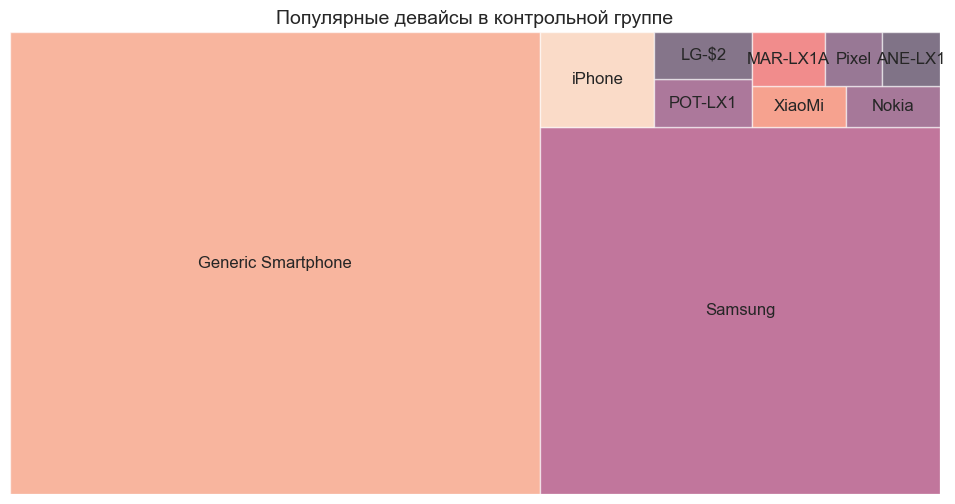

In [35]:
plt.figure(figsize=(12, 6))
squarify.plot(sizes=device_ctr['control'], label=device_ctr.index, alpha=.6, text_kwargs={'fontsize': 12})
plt.axis('off')
plt.title('Популярные девайсы в контрольной группе', fontsize=14)
plt.show()

In [36]:
device_exp = device.sort_values(by='exposed', ascending=False)[0:10][['exposed']]
device_exp

experiment,exposed
general_device,
Generic Smartphone,402
Samsung,177
Pixel,7
Nokia$2$3,6
Nokia,6
I3312,5
LG-$2,5
iPhone,4
OnePlus,4


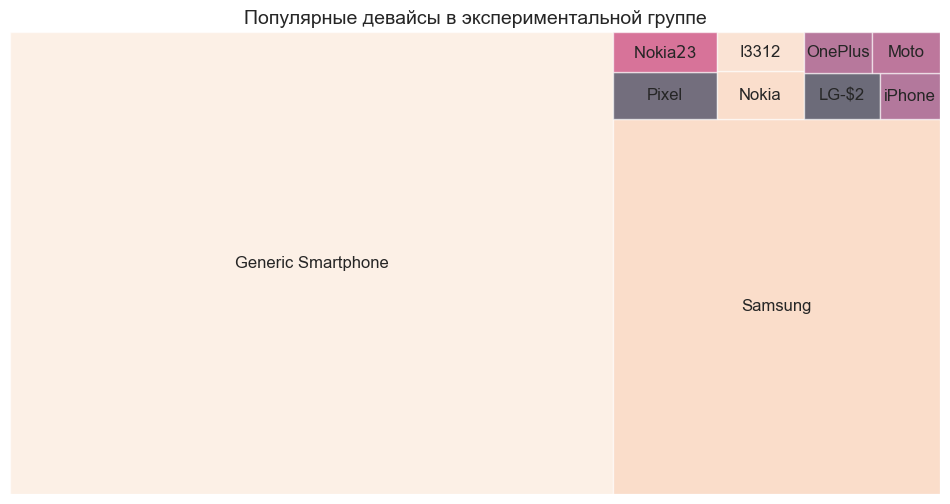

In [37]:
plt.figure(figsize=(12, 6))
squarify.plot(sizes=device_exp['exposed'], label=device_exp.index, alpha=.6, text_kwargs={'fontsize': 12})
plt.axis('off')
plt.title('Популярные девайсы в экспериментальной группе', fontsize=14)
plt.show()

Можем сделать вывод, что существенных отличий в используемых девайсах нет. Как видно, Generic Smartphone занимает наибольшую долю в общих данных, экспериментальной группе и контрольной группе. Второе место в обоих группах занимает Samsung. В контрольной группе iPhone находится на 3 месте, однако в экспериментальной он занимает 8 место и в этой группе его использовали в 3,5 раза реже.

Рассмотрим, с каких девайсов чаще положительно отвечали на анкеты.

In [38]:
device = data_response.pivot_table(index='general_device',
                  columns='response', 
                  values='auction_id',
                  aggfunc='count',
                  fill_value=0, margins=True)
device

response,no,yes,All
general_device,,,
A0001,0,1,1
ANE-LX1,3,3,6
CLT-L09,5,0,5
DLI-L22,1,0,1
E5823,1,0,1
ELE-L09,1,3,4
ELE-L29,1,1,2
EML-L09,1,0,1
EVA-L09,0,1,1


Полученную сводную таблицу отсортируем по итоговому столбцу и выделим первые 10 строк.

In [39]:
device_response = device.sort_values(by='All', ascending=False)[0:10].drop(index=['All'])
device_response

response,no,yes,All
general_device,,,
Generic Smartphone,398,321,719
Samsung,187,180,367
iPhone,13,5,18
LG-$2,2,9,11
Nokia,5,6,11
Pixel,4,7,11
Nokia$2$3,4,5,9
POT-LX1,5,3,8
XiaoMi,3,3,6


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Generic Smartphone'),
  Text(1, 0, 'Samsung'),
  Text(2, 0, 'iPhone'),
  Text(3, 0, 'LG-$2'),
  Text(4, 0, 'Nokia'),
  Text(5, 0, 'Pixel'),
  Text(6, 0, 'Nokia$2$3'),
  Text(7, 0, 'POT-LX1'),
  Text(8, 0, 'XiaoMi')])

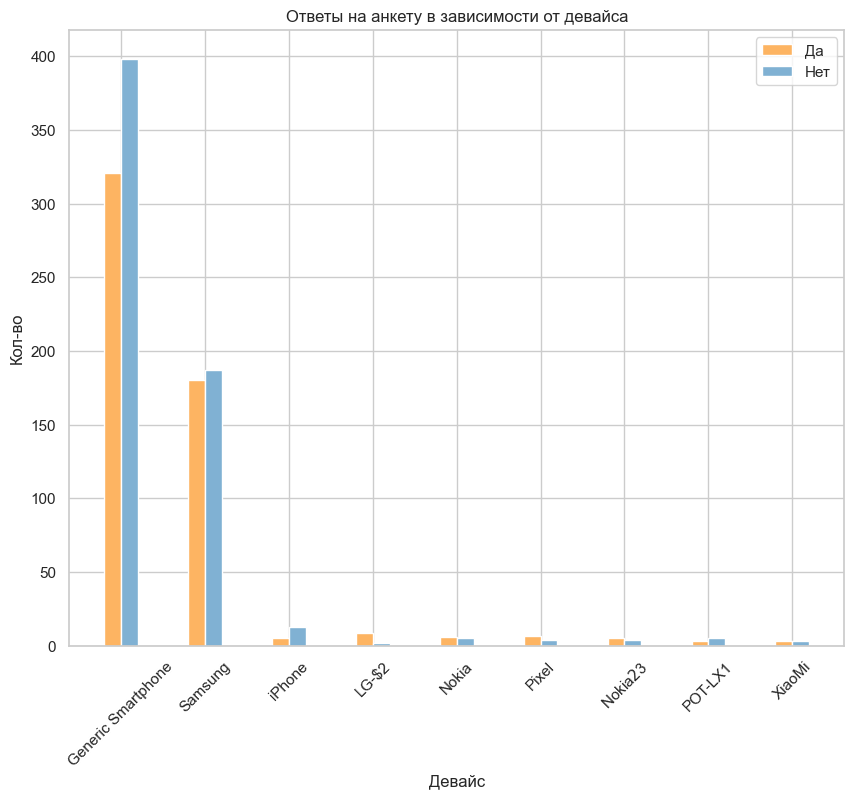

In [40]:
# Строим столбчатую многорядную диаграмму

plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid", palette=['#fdb462','#80b1d3'])
n_ticks = np.arange(len(device_response.index))

offset = 0.1

w = 0.2

plt.bar(n_ticks - offset, device_response['yes'], width=w)
plt.bar(n_ticks + offset, device_response['no'], width=w)

plt.title('Ответы на анкету в зависимости от девайса')
plt.xlabel('Девайс')
plt.ylabel('Кол-во')
plt.legend(['Да', 'Нет'])
plt.xticks(n_ticks, device_response.index)
plt.xticks(rotation = 45)

Как видно, чаще всего положительно на анкету отвечали пользователи Generic Smartphone, Samsung и LG-$2. Построим гистограммы для каждой группы.

C:\Users\annas\AppData\Local\Temp\ipykernel_11372\1188447104.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)


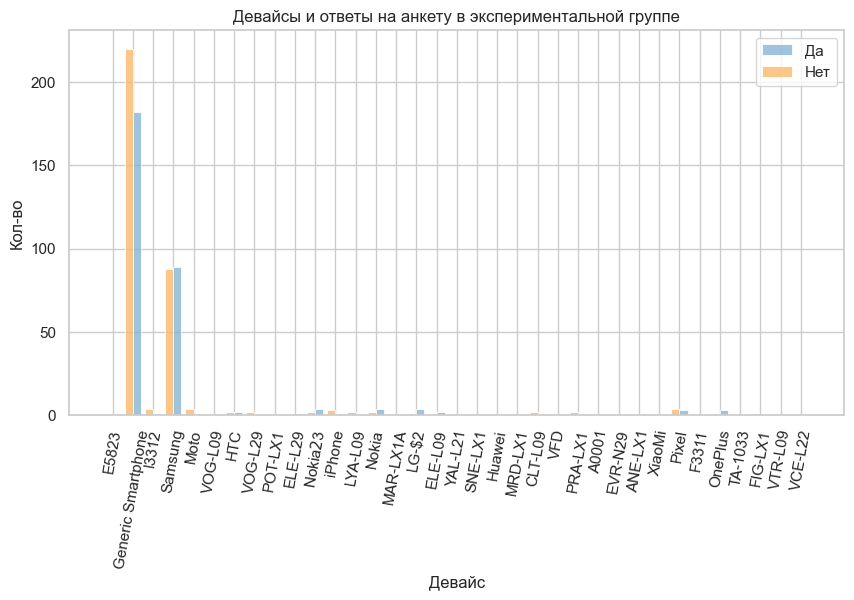

In [41]:
plt.figure(figsize=(10,5))

ax = sns.histplot(data=data_response.loc[df["experiment"] == "exposed"], x="general_device", hue="response", shrink=.8, multiple="dodge", palette=['#fdb462','#80b1d3'])
ax.set_ylabel('Кол-во')
ax.set_xlabel('Девайс')
ax.set_title('Девайсы и ответы на анкету в экспериментальной группе')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
plt.legend(['Да', 'Нет'])

C:\Users\annas\AppData\Local\Temp\ipykernel_11372\3314232451.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)


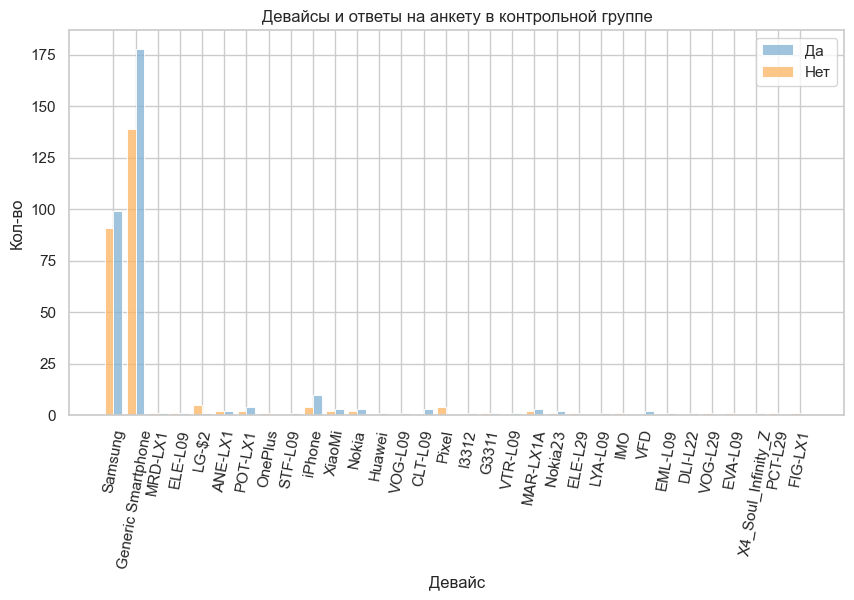

In [42]:
plt.figure(figsize=(10,5))

ax = sns.histplot(data=data_response.loc[df["experiment"] == "control"], x="general_device", hue="response", shrink=.8, multiple="dodge", palette=['#fdb462','#80b1d3'])
ax.set_ylabel('Кол-во')
ax.set_xlabel('Девайс')
ax.set_title('Девайсы и ответы на анкету в контрольной группе')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
plt.legend(['Да', 'Нет'])

Можно заметить, что для Generic Smartphone и Samsung в контрольной группе преобладали положительные ответы. 

### Операционные системы

Рассмотрим, какими операционными системами пользовались в ходе эксперимента все пользователи и те, кто ответил на анкету.

In [43]:
df.platform_os.unique()

array([6, 5, 7], dtype=int64)

In [44]:
data_response.platform_os.unique()

array([6, 5], dtype=int64)

Всего в базе 3 вида операционных систем - 6, 5 и 7. Пользователи с операционной системой 7 не отвечали на анкету.

Рассмотрим распределение используемых операционных систем в каждой группе среди отвеченных анкет.

In [45]:
os = data_response.pivot_table(index='platform_os',
                  columns='experiment', 
                  values='auction_id',
                  aggfunc='count',
                  fill_value=0)
os

experiment,control,exposed
platform_os,,
5,13,4
6,573,653


В обоих группах преобладает platform_os = 6. Визуализируем полученные данные с помощью столбчатой диаграммы.

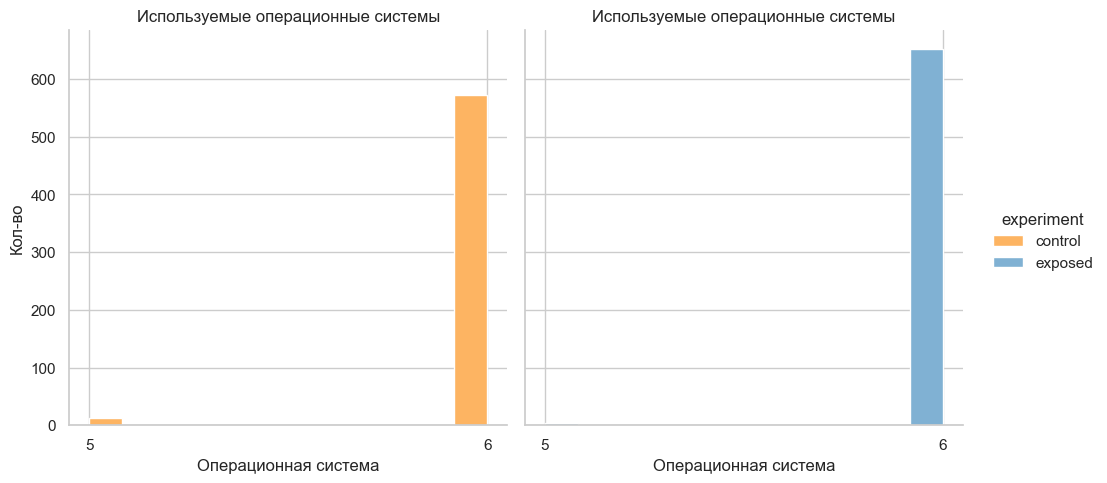

In [46]:
ax = sns.displot(data_response.sort_values(by='experiment'), x='platform_os', 
            col='experiment', hue='experiment', 
            palette=['#fdb462','#80b1d3'], alpha=1).set(xticks=list(range(5,7)))

ax.set_ylabels('Кол-во')
ax.set_xlabels('Операционная система')
ax.set_titles('Используемые операционные системы')

### Браузеры

Выясним, сколько всего разных браузеров в базе данных и в выборке с отвеченными анкетами.

In [47]:
df.browser.nunique()

15

In [48]:
data_response.browser.nunique()

8

Всего 15 разных браузеров и 8 из них попали в выборку с отвеченными анкетами.

Рассмотрим браузеры, с которых отвечали на анкету.

In [49]:
data_response.browser.unique()

array(['Chrome Mobile WebView', 'Chrome Mobile', 'Facebook',
       'Samsung Internet', 'Mobile Safari', 'Chrome',
       'Mobile Safari UI/WKWebView', 'Chrome Mobile iOS'], dtype=object)

Построим сводную таблицу по используемым браузерам для отвеченных анкет и используем метод describe.

In [50]:
browser_response = data_response.pivot_table(index='browser',
                  columns='experiment', 
                  values='auction_id',
                  aggfunc='count',
                  fill_value=0,
                  margins=True)
browser_response

experiment,control,exposed,All
browser,,,
Chrome,1,1,2
Chrome Mobile,324,371,695
Chrome Mobile WebView,47,180,227
Chrome Mobile iOS,1,0,1
Facebook,112,44,156
Mobile Safari,10,4,14
Mobile Safari UI/WKWebView,3,0,3
Samsung Internet,88,57,145
All,586,657,1243


In [51]:
browser_response.describe()

experiment,control,exposed,All
count,9.000000,9.000000,9.000000
mean,130.222222,146.000000,276.222222
std,199.486702,227.774011,424.040911
min,1.000000,0.000000,1.000000
25%,3.000000,1.000000,3.000000
50%,47.000000,44.000000,145.000000
75%,112.000000,180.000000,227.000000
max,586.000000,657.000000,1243.000000


Как видно, в группе exposed минимальное значение равно 0. Браузеры Chrome Mobile iOS и Mobile Safari UI/WKWebView не использовались в экспонированной группе. Есть существенная разница в обоих группах между самыми популярными браузерами и остальным. в контрольной группе 75% браузеров встречалось не более 112 раз, в экспонированной - 180.

Объединим браузеры в основные группы.

In [52]:
def group_browser(row):
    if 'Chrome' in row:
        return 'Chrome'
    elif 'Safari' in row:
        return 'Safari'
    else:
        return row
    
data_response['general_browser'] = data_response['browser'].apply(group_browser)
data_response.general_browser.unique()


C:\Users\annas\AppData\Local\Temp\ipykernel_11372\1549200195.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_response['general_browser'] = data_response['browser'].apply(group_browser)


array(['Chrome', 'Facebook', 'Samsung Internet', 'Safari'], dtype=object)

Выявим соотношение используемых браузеров и определим самые популярные из них. Воспользуемся сводной таблицей.

In [53]:
browser = data_response.pivot_table(index='general_browser',
                  columns='experiment', 
                  values='auction_id',
                  aggfunc='count',
                  fill_value=0,
                  margins=True)
browser

experiment,control,exposed,All
general_browser,,,
Chrome,373,552,925
Facebook,112,44,156
Safari,13,4,17
Samsung Internet,88,57,145
All,586,657,1243


В обоих группах самый популярный браузер Chrome. В контрольной группе на втром месте Facebook, но в экспериметальной группе он использовался в 2,5 раза реже. 
Построим гистограмму распределения используемых браузеров.

Text(0.5, 1.0, 'Распределение используемых браузеров')

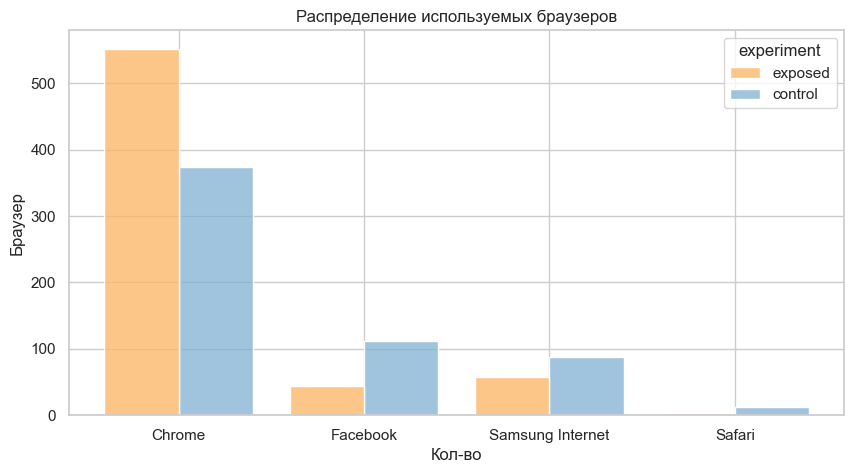

In [71]:
plt.figure(figsize=(10,5))

ax = sns.histplot(data=data_response, x="general_browser", hue="experiment", shrink=.8, multiple="dodge", palette=['#fdb462','#80b1d3'])
ax.set_xlabel('Кол-во')
ax.set_ylabel('Браузер')
ax.set_title('Распределение используемых браузеров')

Также рассмотрим, какое было распределение браузеров в зависимости от ответа на анкету с помощью сводной таблицы.

In [55]:
browser = data_response.pivot_table(index='general_browser',
                  columns='response', 
                  values='auction_id',
                  aggfunc='count',
                  fill_value=0)
browser

response,no,yes
general_browser,,
Chrome,493,432
Facebook,87,69
Safari,13,4
Samsung Internet,78,67


Для всех браузеров преобладал отрицательный ответ. Рассмотрим соотношение ответов на анкету для каждого браузера в экспериментальной и контрольной группе.

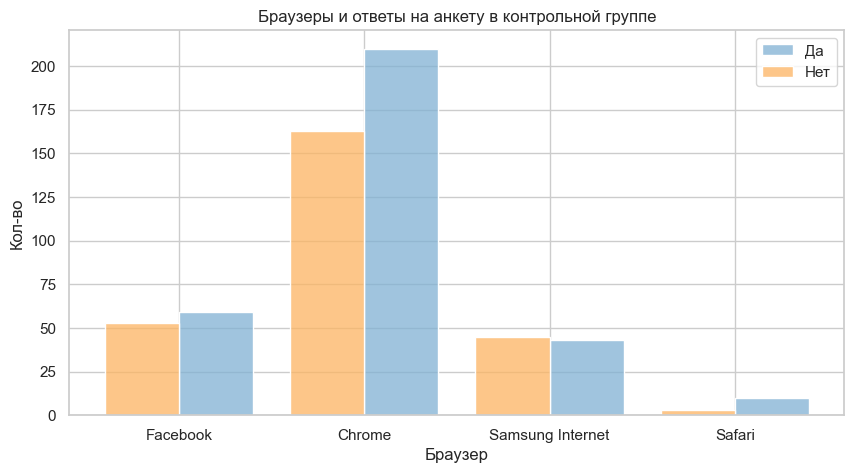

In [72]:
plt.figure(figsize=(10,5))

ax = sns.histplot(data=data_response.loc[df["experiment"] == "control"], x="general_browser", hue="response", shrink=.8, multiple="dodge", palette=['#fdb462','#80b1d3'])
ax.set_ylabel('Кол-во')
ax.set_xlabel('Браузер')
ax.set_title('Браузеры и ответы на анкету в контрольной группе')
plt.legend(['Да', 'Нет'])

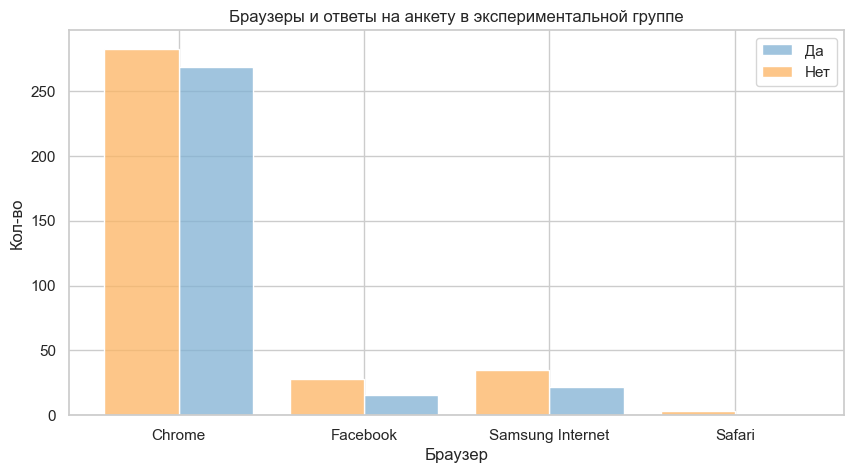

In [73]:
plt.figure(figsize=(10,5))

ax = sns.histplot(data=data_response.loc[df["experiment"] == "exposed"], x="general_browser", hue="response", shrink=.8, multiple="dodge", palette=['#fdb462','#80b1d3'])
ax.set_ylabel('Кол-во')
ax.set_xlabel('Браузер')
ax.set_title('Браузеры и ответы на анкету в экспериментальной группе')
plt.legend(['Да', 'Нет'])

Можно сделать вывод, что чаще всего положительно отвечали на анкету в обоих группах при просмотре с браузеров Chrome, Facebook и Samsung Internet. В контрольной группе для браузера Chrome преобладают положительные ответы. В экспериментальной группе для всех браузеров преобладают отрицательные ответы.

### Выводы:
1. Преобладают неотвеченные анкеты в обоих группах - обычно (~83-85%) пользователи не отвечают на вопросы анкеты. Разницы в ответах на анкету в обоих группах не наблюдается - 45-47% приходится на ответ "yes" и 55-53% - на ответ "no".
2. Размеры контрольной и экспонированной групп аналогичны.
3. В течение всего эксперимента, кроме первого дня, количество пользователей было немного выше в экспериментальной группе. 
4. На 03.07.2020 в 15 часов в контрольной группе было аномальное количество пользователей (1673), хотя среднее значение равно 170.
4. Самыми популярными девайсами являются Generic Smartphone, Samsung, iPhone. Существенных отличий в группах по девайсам нет.
5. Чаще всего пользователи в обоих группах использовали операционнную систему 6.
6. Самые популярные браузеры: Chrome, Samsung, Facebook и Safari. 

## Статистический анализ

Чтобы понять, как новая реклама меняет коэффициент конверсии, мы должны оценить, значительна ли разница между результатами старой и новой рекламы.

### Формулировка гипотезы
**Нулевая гипотеза Hₒ: p = pₒ** — нет существенной разницы между показателем успешности рекламы в обеих группах.\
**Альтернативная гипотеза Hₐ: p ≠ pₒ** — существует значительная разница между показателями успешности рекламы в обеих группах.\
Поскольку мы не знаем, будет ли новый дизайн работать лучше/хуже/равно нашему текущему дизайну, мы проведем двусторонний тест.\
Уровень достоверности: 95% (α=0,05)\
p и pₒ обозначают коэффициент конверсии нового и старого дизайна.

### Критерий Фишера
**Обзор**
* Точный критерий Фишера можно использовать, чтобы показать, как переменные различаются между группами.
* Есть несколько предположений для теста Фишера:

1. Случайная выборка - в каждой группе точка данных должна быть из случайной выборки.

2. Независимость - каждое наблюдение должно быть независимым.

3. Взаимоисключающие группы — каждая категория должна быть взаимоисключающей.

* Все эти предположения справедливы для нашего случая:

1. Все пользователи из каждой группы случайны без какой-либо предвзятости,
2. Каждый пользователь принял самостоятельное решение,
3. Ответ взаимный — либо «да», либо «нет».

**Расчеты**

In [58]:
contingency = pd.pivot_table(data=data_response, index='experiment', columns='response', aggfunc='count')['auction_id']

contingency

response,no,yes
experiment,,
control,322,264
exposed,349,308


In [59]:
odds_ratio, p_value = stats.fisher_exact(contingency, alternative="two-sided")

print('P-значение теста Фишера: {:.2f}'.format(p_value))

P-значение теста Фишера: 0.53


**Вывод**:
* P-значение теста Фишера равно 0,53, поэтому мы не можем отвергнуть гипотезу Hₒ.
* Результат: нет существенной разницы между коэффициентом конверсии в контрольной и экспонированной группах.

### Доверительный интервал
**Обзор**
* Мы можем провести A/B-тестирование, используя доверительные интервалы.
* Предел погрешности рассчитывается на основе предполагаемого стандартного отклонения параметра, умноженного на Z-оценку, соответствующую выбранному уровню достоверности.
* Границы доверительного интервала для абсолютной разницы между двумя средними значениями рассчитываются по следующему уравнению:
![Границы доверительного интервала](bounds%20of%20a%20confidence%20interval.png "Формула границ доверительного интервала")
где:
μ1 — среднее значение базовой или контрольной группы.\
μ2 — среднее значение группы обработки.\
n1 - размер выборки базовой или контрольной группы.\
n2 - размер выборки группы обработки.\
σp — объединенное стандартное отклонение двух групп.\
Z является оценочной статистикой, соответствующей желаемому уровню достоверности.
* Границы интервала зависят от:
 1. Случайная ошибка, вызванная наблюдаемой разницей в средних значениях;
 2. Ошибка в оценке стандартного отклонения указанной разницы.

**Расчеты**
* Рассчитать z-показатель для доверительного интервала 95%;
* По сути, z-показатель для определенного интервала определяет, насколько мы должны отклоняться от среднего значения нормального распределения в обоих направлениях, чтобы покрыть 95% значений данных вокруг среднего.
![zcsore](zscore.png "z-показатель")

In [60]:
zscore = norm.ppf(1 - .05/2)

print('Z-показатель = {:.2f}'.format(zscore))

Z-показатель = 1.96


Расчет среднего значения для обеих групп:

In [61]:
e_mean = data_response.query('experiment=="exposed"')['yes'].mean()
c_mean = data_response.query('experiment=="control"')['yes'].mean()

Теперь необходимо рассчитать объединенную дисперсию для двух групп.

In [62]:
e_std = data_response.query('experiment=="exposed"')['yes'].std()
c_std = data_response.query('experiment=="control"')['yes'].std()

e_num = data_response.query('experiment=="exposed"')['yes'].shape[0]
c_num = data_response.query('experiment=="exposed"')['yes'].shape[0]

In [63]:
var_pooled = (((e_num-1)*e_std**2 + (c_num-1)*c_std**2)/(e_num+c_num-2))**0.5

Расчет верхней и нижней границы доверительного интервала:

In [64]:
CI_low = (e_mean - c_mean) - zscore * var_pooled * (1/e_num + 1/c_num)**.5
CI_high = (e_mean - c_mean) + zscore * var_pooled * (1/e_num + 1/c_num)**.5

**Построение графика**

Узнаем биномиальное распределение на основе рассчитанных групповых средних:

In [65]:
e_binom = np.random.binomial(e_num, e_mean, 100000)/e_num

c_binom = np.random.binomial(c_num, c_mean, 100000)/c_num

diff_binom = e_binom - c_binom

Рассчитаем нормальное распределение:

In [66]:
norm_dist = np.random.normal(0, np.std(diff_binom), len(diff_binom))

Построим на основе полученных данных график

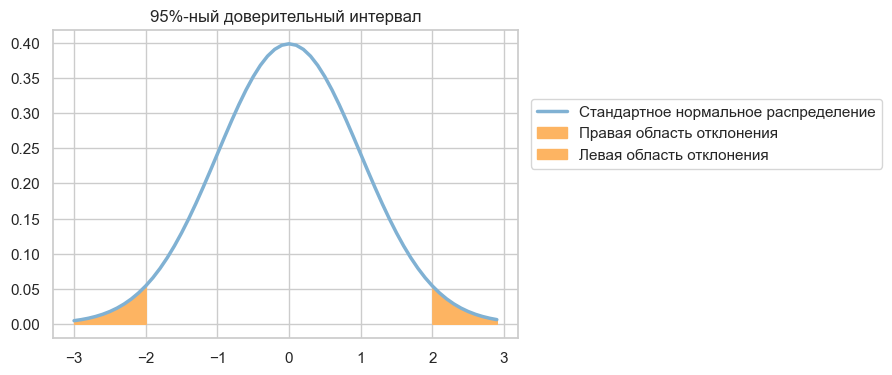

In [67]:
z = np.arange(-3,3,  0.1)
plt.figure(figsize=(6,4))
plt.plot(z, norm.pdf(z), label = 'Стандартное нормальное распределение', linewidth = 2.5, color ='#80b1d3')
plt.fill_between(z[z>zscore], norm.pdf(z[z>zscore]), label = 'Правая область отклонения', color ='#fdb462' )
plt.fill_between(z[z<(-1)*zscore], norm.pdf(z[z<(-1)*zscore]), label = 'Левая область отклонения', color ='#fdb462' )
plt.title("95%-ный доверительный интервал")
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.8))
plt.show()

In [68]:
print('95%-ный доверительный интервал: [{:.2f}, {:.2f}]'.format(CI_low, CI_high))

95%-ный доверительный интервал: [-0.04, 0.07]


Доверительный интервал говорит нам, что с 95%-ной уверенностью разница между двумя средними находится между [-0,04, 0,07], что означает, что мы не можем отвергнуть нулевую гипотезу.\
Мы можем сделать вывод, что нет существенной разницы между показателями конверсии для старой и новой рекламы.

### Вывод
По результатам проведенного А/В теста с точным критерием Фишера и доверительным интервалом можно сделать вывод, что новый дизайн рекламы не изменил коэффициент конверсии.